<a href="https://colab.research.google.com/github/alexaugur/Collab/blob/main/experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense, Lambda, Conv1D, MaxPooling1D, Reshape
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
k = 8                       # number of information bits
N = 16                      # code length
train_SNR_Eb = 1            # training-Eb/No

nb_epoch = 2**16            # number of learning epochs
code = 'polar'              # type of code ('random' or 'polar')
design = [128, 64, 32]      # each list entry defines the number of nodes in a layer
batch_size = 256            # size of batches for calculation the gradient
LLR = False                 # 'True' enables the log-likelihood-ratio layer
optimizer = 'adam'
loss = 'mse'                # or 'binary_crossentropy'

train_SNR_Es = train_SNR_Eb + 10*np.log10(k/N)
train_sigma = np.sqrt(1/(2*10**(train_SNR_Es/10)))

define nn model:


In [ ]:
def modulateBPSK(x):
    return -2*x +1;

def addNoise(x, sigma):
    w = K.random_normal(K.shape(x), mean=0.0, stddev=sigma) #std=sigma added last two params
    return x + w

def ber(y_true, y_pred):
    return K.mean(K.not_equal(y_true, K.round(y_pred)))

def return_output_shape(input_shape):
    return input_shape

def compose_model(layers):
    model = Sequential()
    for layer in layers:
        model.add(layer)
    return model

def log_likelihood_ratio(x, sigma):
    return 2*x/np.float32(sigma**2)


def errors(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(K.round(y_pred), 'float32')
    return K.sum(K.cast(K.not_equal(y_true, y_pred), 'float32' ))




In [ ]:

# function to define the decoder and model to train
#param llr - bool whether model uses llr before net
#param train_sigma - the std of the training noise
def create_decoder_model(llr, train_sigma, convolutional=False):


  modulator_layers = [Lambda(modulateBPSK,
                          input_shape=(N,), output_shape=return_output_shape, name="modulator")]
  modulator = compose_model(modulator_layers)
  modulator.compile(optimizer=optimizer, loss=loss)

  # Define noise
  noise_layers = [Lambda(addNoise, arguments={'sigma':train_sigma},
                       input_shape=(N,), output_shape=return_output_shape, name="noise")]
  noise = compose_model(noise_layers) #creates a keras sequential model with the layers passed as params
  noise.compile(optimizer=optimizer, loss=loss)

  # Define LLR
  llr_layers = [Lambda(log_likelihood_ratio, arguments={'sigma':train_sigma},
                     input_shape=(N,), output_shape=return_output_shape, name="LLR")]
  llr = compose_model(llr_layers)
  llr.compile(optimizer=optimizer, loss=loss)



  # Define decoder
  if convolutional:
    decoder_layers = [Reshape((16,1))]
    decoder_layers.append(Conv1D(16, 3, activation='relu'))
    #decoder_layers.append(MaxPooling1D(pool_size=2, strides=1))
    decoder_layers.append(Conv1D(32, 5, activation='relu'))
    #decoder_layers.append(MaxPooling1D(pool_size=2, strides=1))
    decoder_layers.append(Conv1D(64, 3, activation='relu'))
    decoder_layers.append(Reshape((-1, 512)))
    decoder_layers.append(Dense(k, activation='relu'))
    decoder = compose_model(decoder_layers)
    decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])
  else:

    decoder_layers = [Dense(design[0], activation='relu', input_shape=(N,))]
    for i in range(1,len(design)):
      decoder_layers.append(Dense(design[i], activation='relu'))
    decoder_layers.append(Dense(k, activation='sigmoid'))
    decoder = compose_model(decoder_layers)
    decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])

  # Define model
  if LLR:
    model_layers = modulator_layers + noise_layers + llr_layers + decoder_layers
  else:
    model_layers = modulator_layers + noise_layers + decoder_layers

  model = compose_model(model_layers)
  model.compile(optimizer=optimizer, loss=loss, metrics=[ber])

  return decoder, model



data generation:


In [ ]:
def half_adder(a,b):
    s = a ^ b
    c = a & b
    return s,c

def full_adder(a,b,c):
    s = (a ^ b) ^ c
    c = (a & b) | (c & (a ^ b))
    return s,c

def add_bool(a,b):
    if len(a) != len(b):
        raise ValueError('arrays with different length')
    k = len(a)
    s = np.zeros(k,dtype=bool)
    c = False
    for i in reversed(range(0,k)):
        s[i], c = full_adder(a[i],b[i],c)
    if c:
        warnings.warn("Addition overflow!")
    return s

def inc_bool(a):
    k = len(a)
    increment = np.hstack((np.zeros(k-1,dtype=bool), np.ones(1,dtype=bool)))
    a = add_bool(a,increment)
    return a

def bitrevorder(x):
    m = np.amax(x)
    n = np.ceil(np.log2(m)).astype(int)
    for i in range(0,len(x)):
        x[i] = int('{:0{n}b}'.format(x[i],n=n)[::-1],2)
    return x

def int2bin(x,N):
    if isinstance(x, list) or isinstance(x, np.ndarray):
        binary = np.zeros((len(x),N),dtype='bool')
        for i in range(0,len(x)):
            binary[i] = np.array([int(j) for j in bin(x[i])[2:].zfill(N)])
    else:
        binary = np.array([int(j) for j in bin(x)[2:].zfill(N)],dtype=bool)

    return binary

def bin2int(b):
    if isinstance(b[0], list):
        integer = np.zeros((len(b),),dtype=int)
        for i in range(0,len(b)):
            out = 0
            for bit in b[i]:
                out = (out << 1) | bit
            integer[i] = out
    elif isinstance(b, np.ndarray):
        if len(b.shape) == 1:
            out = 0
            for bit in b:
                out = (out << 1) | bit
            integer = out
        else:
            integer = np.zeros((b.shape[0],),dtype=int)
            for i in range(0,b.shape[0]):
                out = 0
                for bit in b[i]:
                    out = (out << 1) | bit
                integer[i] = out

    return integer

def polar_design_awgn(N, k, design_snr_dB):

    S = 10**(design_snr_dB/10)
    z0 = np.zeros(N)

    z0[0] = np.exp(-S)
    for j in range(1,int(np.log2(N))+1):
        u = 2**j
        for t in range(0,int(u/2)):
            T = z0[t]
            z0[t] = 2*T - T**2     # upper channel
            z0[int(u/2)+t] = T**2  # lower channel

    # sort into increasing order
    idx = np.argsort(z0)

    # select k best channels
    idx = np.sort(bitrevorder(idx[0:k]))

    A = np.zeros(N, dtype=bool)
    A[idx] = True

    return A

def polar_transform_iter(u):

    N = len(u)
    n = 1
    x = np.copy(u)
    stages = np.log2(N).astype(int)
    for s in range(0,stages):
        i = 0
        while i < N:
            for j in range(0,n):
                idx = i+j
                x[idx] = x[idx] ^ x[idx+n]
            i=i+2*n
        n=2*n
    return x

def generate_random_code(x, idx, N, dist):
  x[idx, :] = np.random.randint(0,2,size=(1,N), dtype=bool)
  for k in range(idx):
    sum = np.sum(x[idx, :] == x[k, :]) #amount of bits in common
    if sum > N - dist:
      generate_random_code(x, idx, N, dist)

def is_independent(matrix):
    return np.linalg.matrix_rank(matrix) == matrix.shape[1]

#get a low density matrix of a certain rank
def rank_mat(k, N):
  m = np.random.choice([True, False], size=(N-k, N)).astype(int)
  if (np.sum(m)< ((N-k)*N)/2 or np.linalg.matrix_rank(m) != N-k):
    return m
  else:
    return rank_mat(k, N)


def generate_pcheck_ir(k, N):
  m = rank_mat(k, N)
  n = m.shape[1]
  for i in range(k):
      for j in range(i, n):
        temp_matrix = m[:, list(range(i)) + [j]]
        if is_independent(temp_matrix):
          # Swap columns
          m[:, [i, j]] = m[:, [j, i]]
          break
  return m


def obtain_generator(k, N, parity_check):
    inter = parity_check.astype(int)
    #inter = np.concatenate([inter[:, N -  k:], inter[:, :N - k]], axis=1)
    inter = gf2elim2(inter)


    '''
    for i in range(N-k):

      if inter[i][i] != 1 or np.sum(inter[:, i]) != 1:
        for j in range(i+1,N):
          if inter[i][j] == 1 and np.sum(inter[:, j]) == 1:
             #inter[:, [i, j]] = inter[:, [j, i]]
             col = inter[:, j]
             inter[:, i] = inter[:, j]
             inter[:, j] = col
    '''

    inter = np.concatenate([ inter[:, k:].T, inter[:, :k]], axis=1)
    return inter.astype(bool)


def gf2elim2(M):
    m, n = M.shape
    i = 0
    j = 0
    while i < m and j < n:
        # Find row with a non-zero element in column j
        non_zero_row = None
        for k in range(i, m):
            if M[k, j] == 1:
                non_zero_row = k
                break

        if non_zero_row is not None:
            # Swap rows
            M[[i, non_zero_row]] = M[[non_zero_row, i]]

            # Perform XOR operation for all rows except the pivot row
            for u in range(m):
                if u != i and M[u, j] == 1:
                    M[u, :] = M[u, :] ^ M[i, :]

            i += 1
        j += 1

    return M





In [ ]:
#function to create the test and train datasets for given code and datalengths
#param code for type of code (polar of random)
#returns test and train sets of data
def generate_data(k, N, code):
  # Create all possible information words
  d = np.zeros((2**k,k),dtype=bool)
  for i in range(1,2**k):
    d[i]= inc_bool(d[i-1])

  # Create sets of all possible codewords (codebook)
  if code == 'polar':

    A = polar_design_awgn(N, k, design_snr_dB=0)  # logical vector indicating the nonfrozen bit locations
    x = np.zeros((2**k, N),dtype=bool)
    u = np.zeros((2**k, N),dtype=bool)
    u[:,A] = d

    for i in range(0,2**k):
        x[i] = polar_transform_iter(u[i])
    print(x.shape)
  elif code == 'random':

    #weight 2 codeword


    np.random.seed(4267)
    x = np.zeros((2**k, N),dtype=bool)
    # for a 16bit Random Code (r=0.5) with Hamming distance >= 2
    for i in range(2**k):
      generate_random_code(x, i, N, 2)
  elif code == 'random_linear':

    p_check = generate_pcheck_ir(k, N)
    gen = obtain_generator(k, N, p_check)
    x = (np.dot(d.astype(int), gen.astype(int)) % 2).astype(bool)




  return x, d

test neural net

In [ ]:
#evaluate the effectiveness on the model for a range of different sigmas
def evaluate_model(x, decoder, LLR, code, test_batch, num_words, sigmas):

  nb_errors = np.zeros(len(sigmas),dtype=int)
  nb_bits = np.zeros(len(sigmas),dtype=int)

  for i in range(0,int(len(sigmas))):

      for ii in range(0,np.round(num_words/test_batch).astype(int)):

          # Source
          np.random.seed(0)
          d_test = np.random.randint(0,2,size=(test_batch,k))

          # Encoder
          if code == 'polar':
              x_test = np.zeros((test_batch, N),dtype=bool)
              u_test = np.zeros((test_batch, N),dtype=bool)
              A = polar_design_awgn(N, k, design_snr_dB=0)
              u_test[:,A] = d_test

              for iii in range(0,test_batch):
                  x_test[iii] = polar_transform_iter(u_test[iii])

          elif code == 'random' or code =="random_linear":
              x_test = np.zeros((test_batch, N),dtype=bool)
              for iii in range(0,test_batch):
                  x_test[iii] = x[bin2int(d_test[iii])]



          # Modulator (BPSK)
          s_test = -2*x_test + 1

          # Channel (AWGN)
          y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)

          if LLR:
              y_test = 2*y_test/(sigmas[i]**2)

          # Decoder
          nb_errors[i] += (decoder.evaluate(y_test, d_test, batch_size=test_batch, verbose=0))[1]
          nb_bits[i] += d_test.size
  return nb_errors, nb_bits

In [ ]:
test_batch = 1000
num_words = 100000      # multiple of test_batch

SNR_dB_start_Eb = 0
SNR_dB_stop_Eb = 5
SNR_points = 20
SNR_dB_start_Es = SNR_dB_start_Eb + 10*np.log10(k/N)
SNR_dB_stop_Es = SNR_dB_stop_Eb + 10*np.log10(k/N)

sigma_start = np.sqrt(1/(2*10**(SNR_dB_start_Es/10)))
sigma_stop = np.sqrt(1/(2*10**(SNR_dB_stop_Es/10)))

sigmas = np.linspace(sigma_start, sigma_stop, SNR_points)

evaluate model for polar codes

In [ ]:
decoder, model = create_decoder_model(LLR, train_sigma)
x, d = generate_data(k, N, code)

#prints out the summary of the model
model.summary()

#noise and modulator is built into model so it generates different noise for ever epoch
history = model.fit(x, d, batch_size=batch_size, epochs=nb_epoch, verbose=0, shuffle=True)

In [ ]:

pol_errors, pol_bits = evaluate_model(x, decoder, LLR, code, test_batch, num_words, sigmas)

load map data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
result_map = np.loadtxt('/content/drive/MyDrive/research/results_{}_map_{}_{}.txt'.format(code,N,k), delimiter=',')
sigmas_map = result_map[:,0]
nb_bits_map = result_map[:,1]
nb_errors_map = result_map[:,2]




```
# This is formatted as code
```

Plot Bit-Error_Rate

(epcohs = 2^16, trained on channel w gaussian noise w an eb/no of 1)


In [ ]:
legend = []

plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), pol_errors/pol_bits)
legend.append('NN')

plt.plot(10*np.log10(1/(2*sigmas_map**2)) - 10*np.log10(k/N), nb_errors_map/nb_bits_map)
legend.append('MAP')

plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')
plt.grid(True)
plt.show()

NameError: name 'pol_errors' is not defined

plot BER for random codes

In [ ]:
code = 'random'
design = [128, 64, 32]
decoder, model = create_decoder_model(LLR, train_sigma)
x, d = generate_data(k, N, code)
history = model.fit(x, d, batch_size=batch_size, epochs=nb_epoch, verbose=0, shuffle=True)

rand_errors, rand_bits = evaluate_model(x, decoder, LLR, code, test_batch, num_words, sigmas)


In [ ]:
result_map = np.loadtxt('/content/drive/MyDrive/research/results_{}_map_{}_{}.txt'.format(code,N,k), delimiter=',')
sigmas_map = result_map[:,0]
nb_bits_map = result_map[:,1]
nb_errors_map = result_map[:,2]

legend = []

plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), rand_errors/rand_bits)
legend.append('NN')

plt.plot(10*np.log10(1/(2*sigmas_map**2)) - 10*np.log10(k/N), nb_errors_map/nb_bits_map)
legend.append('MAP')

plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')
plt.grid(True)
plt.show()


NameError: ignored

BER vs Noise for different epochs (polar code)

In [ ]:
code = 'polar'
epochs = [2**10, 2**12, 2**14, 2**16, 2**18]


#2d lists  - each list is a different epoch length and the data within the list corresponds to different SNRs
errors_ep = []
bits_ep = []


#train and evaluate the model for each amount of epochs
for e in epochs:
  decoder, model = create_decoder_model(LLR, train_sigma)
  x, d = generate_data(k, N, code)
  history = model.fit(x, d, batch_size=batch_size, epochs=e, verbose=0, shuffle=True)

  sig_errors = []
  sig_bits = []

  sig_errors, sig_bits = evaluate_model(x, decoder, LLR, code, test_batch, num_words, sigmas)

  errors_ep.append(sig_errors)
  bits_ep.append(sig_bits)

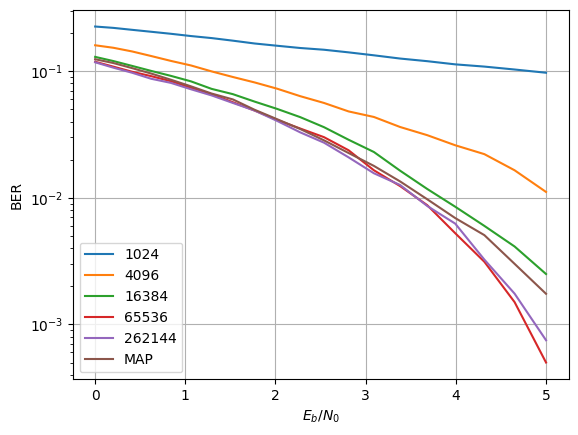

In [ ]:
legend = []
for i in range (len(epochs)):
  plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), errors_ep[i]/bits_ep[i])
  #legend.append('$M_e = 2^{0}$'.format(epochs[i]))
  legend.append(str(epochs[i]))


result_map = np.loadtxt('/content/drive/MyDrive/research/results_{}_map_{}_{}.txt'.format(code,N,k), delimiter=',')
sigmas_map = result_map[:,0]
nb_bits_map = result_map[:,1]
nb_errors_map = result_map[:,2]
plt.plot(10*np.log10(1/(2*sigmas_map**2)) - 10*np.log10(k/N), nb_errors_map/nb_bits_map)
legend.append('MAP')

plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')

plt.grid(True)
plt.show()


BER vs Noise for different epochs (random code)

In [ ]:
code = 'random'
epochs = [2**10, 2**12, 2**14, 2**16, 2**18]


#2d lists  - each list is a different epoch length and the data within the list corresponds to different SNRs
errors_ep = []
bits_ep = []


#train and evaluate the model for each amount of epochs
for e in epochs:
  decoder, model = create_decoder_model(LLR, train_sigma)
  x, d = generate_data(k, N, code)
  history = model.fit(x, d, batch_size=batch_size, epochs=e, verbose=0, shuffle=True)

  sig_errors = []
  sig_bits = []

  sig_errors, sig_bits = evaluate_model(x, decoder, LLR, code, test_batch, num_words, sigmas)

  errors_ep.append(sig_errors)
  bits_ep.append(sig_bits)

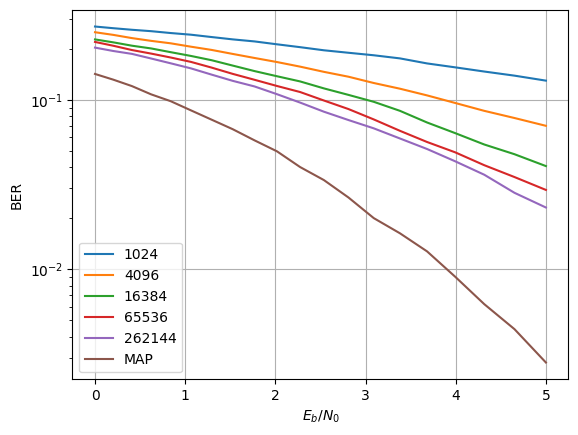

In [ ]:
legend = []
for i in range(len(epochs)):
  plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), errors_ep[i]/bits_ep[i])
  legend.append(str(epochs[i]))


result_map = np.loadtxt('/content/drive/MyDrive/research/results_{}_map_{}_{}.txt'.format(code,N,k), delimiter=',')
sigmas_map = result_map[:,0]
nb_bits_map = result_map[:,1]
nb_errors_map = result_map[:,2]
plt.plot(10*np.log10(1/(2*sigmas_map**2)) - 10*np.log10(k/N), nb_errors_map/nb_bits_map)
legend.append('MAP')

plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')

plt.grid(True)
plt.show()

nve function

In [ ]:

#function to compute the normal validation error
#Specifically for test noise levels between 0 and 5 db with 20 steps.
#Currently that is the MAP data we have, but will explore creating
#a more complex function
def get_nve(code, N, k, errors, bits):
  result_map_nve = np.loadtxt('/content/drive/MyDrive/research/results_{}_map_{}_{}.txt'.format(code,N,k), delimiter=',')
  nb_bits_map_nve = result_map_nve[:,1]
  nb_errors_map_nve = result_map_nve[:,2]

  nve = 0
  #assuming that MAP data is for same range and step of sigmas
  for i in range(20):
    #nve += (errors[i]/bits[i] )/ (nb_errors_map[i] / nb_bits_map [i])
    nve += (errors[i] / bits[i]) / (nb_errors_map_nve[i] / nb_bits_map_nve[i])
  nve = nve / 20
  return nve


BER/NVE for networks
trained on different snrs

In [ ]:

train_ebno_start = -2
train_ebno_stop = 6
train_sigma_start = np.sqrt(1/(2*10**((train_ebno_start + 10*np.log10(k/N))/10)))
train_sigma_stop = np.sqrt(1/(2*10**((train_ebno_stop + 10*np.log10(k/N))/10)))
train_sigmas = np.linspace(train_sigma_start, train_sigma_stop, 5)

In [ ]:
code = 'polar'
#reminder that the test sigmas list (var name = sigmas) is still between 0 and 5 dB w 20 points - so is the MAP data

nves = []

errors_ts = []
bits_ts = []

#validation set size of 20000
num_words = 20000

for sigma in train_sigmas:
  decoder, model = create_decoder_model(LLR, sigma)
  x, d = generate_data(k, N, code)
  model.fit(x, d, batch_size=batch_size, epochs=nb_epoch, verbose=0, shuffle=True)

  sig_errors = []
  sig_bits = []

  sig_errors, sig_bits = evaluate_model(x, decoder, LLR, code, test_batch, num_words, sigmas)

  errors_ts.append(sig_errors)
  bits_ts.append(sig_bits)
  nve = get_nve(code, N, k, sig_errors, sig_bits)
  nves.append(nve)



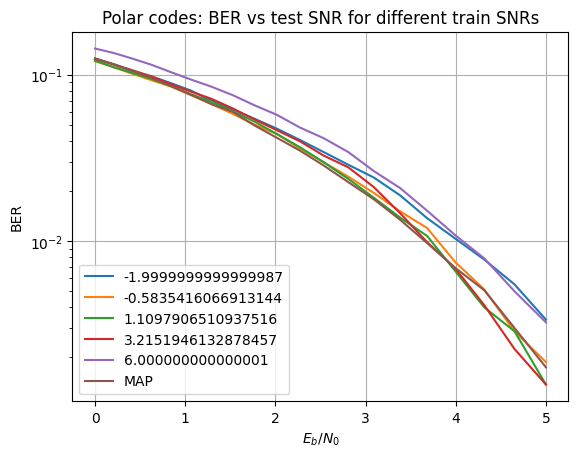

In [ ]:
legend = []
for i in range (len(train_sigmas)):
  plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), errors_ts[i]/bits_ts[i])
  train_ebno = 10*np.log10(1/(2*train_sigmas[i]**2)) - 10*np.log10(k/N)
  legend.append(str(train_ebno))


result_map = np.loadtxt('/content/drive/MyDrive/research/results_{}_map_{}_{}.txt'.format(code,N,k), delimiter=',')
sigmas_map = result_map[:,0]
nb_bits_map = result_map[:,1]
nb_errors_map = result_map[:,2]
plt.plot(10*np.log10(1/(2*sigmas_map**2)) - 10*np.log10(k/N), nb_errors_map/nb_bits_map)
legend.append('MAP')

plt.title('Polar codes: BER vs test SNR for different train SNRs')
plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')

plt.grid(True)
plt.show()

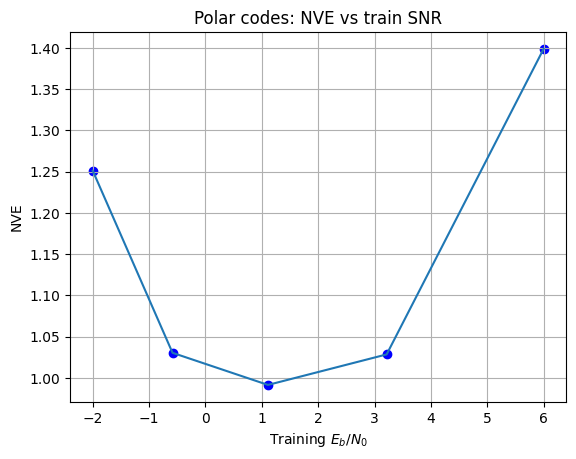

In [ ]:
plt.plot(10*np.log10(1/(2*train_sigmas**2)) - 10*np.log10(k/N), nves)
plt.scatter(10*np.log10(1/(2*train_sigmas**2)) - 10*np.log10(k/N), nves, color='blue', marker='o')

plt.title('Polar codes: NVE vs train SNR')
plt.xlabel('Training $E_b/N_0$')
plt.ylabel('NVE')

plt.grid(True)
plt.show()


trained on different snrs - random codes

In [ ]:
code = 'random'
nves_ra = []

errors_ts_ra = []
bits_ts_ra = []

for sigma in train_sigmas:
  decoder, model = create_decoder_model(LLR, sigma)
  x, d = generate_data(k, N, code)
  history = model.fit(x, d, batch_size=batch_size, epochs=nb_epoch, verbose=0, shuffle=True)

  sig_errors = []
  sig_bits = []

  sig_errors, sig_bits = evaluate_model(x, decoder, LLR, code, test_batch, num_words, sigmas)

  errors_ts_ra.append(sig_errors)
  bits_ts_ra.append(sig_bits)
  nve = get_nve(code, N, k, sig_errors, sig_bits)
  nves_ra.append(nve)



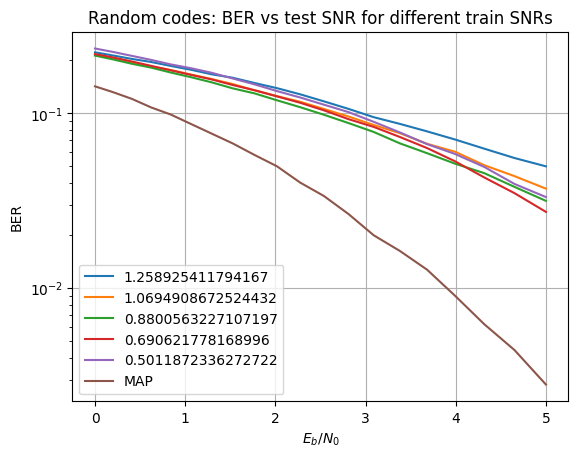

In [ ]:
legend = []
for i in range (len(train_sigmas)):
  plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), errors_ts_ra[i]/bits_ts_ra[i])
  legend.append(str(train_sigmas[i]))


result_map = np.loadtxt('/content/drive/MyDrive/research/results_{}_map_{}_{}.txt'.format(code,N,k), delimiter=',')
sigmas_map = result_map[:,0]
nb_bits_map = result_map[:,1]
nb_errors_map = result_map[:,2]
plt.plot(10*np.log10(1/(2*sigmas_map**2)) - 10*np.log10(k/N), nb_errors_map/nb_bits_map)
legend.append('MAP')

plt.title('Random codes: BER vs test SNR for different train SNRs')
plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')

plt.grid(True)
plt.show()

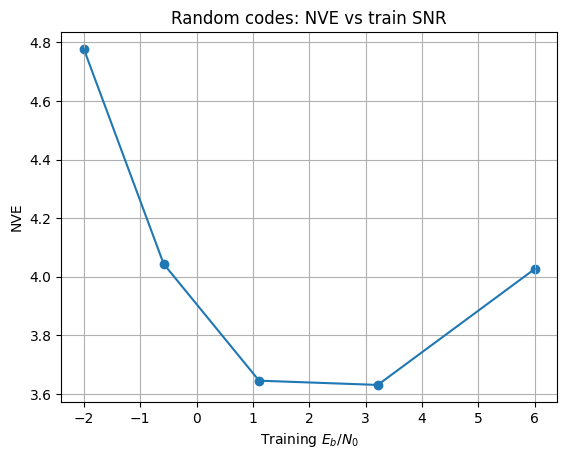

In [ ]:
plt.plot(10*np.log10(1/(2*train_sigmas**2)) - 10*np.log10(k/N), nves_ra)
plt.scatter(10*np.log10(1/(2*train_sigmas**2)) - 10*np.log10(k/N), nves_ra)

plt.title('Random codes: NVE vs train SNR')
plt.xlabel('Training $E_b/N_0$')
plt.ylabel('NVE')

plt.grid(True)
plt.show()

Effect of different architectures

In [ ]:
archs = [[128, 64, 32], [256, 128, 64], [512, 256, 128], [1024, 512, 256]]

In [ ]:


arc_errors_p_full = []
arc_bits_p_full = []
arc_errors_r_full = []
arc_bits_r_full = []

for a in archs:
    design = a #global var?? used in the create model function

    code = 'polar'
    decoder, model = create_decoder_model(LLR, train_sigma)
    x, d = generate_data(k, N, code)


    model.fit(x, d, batch_size=batch_size, epochs=nb_epoch, verbose=0, shuffle=True)

    arc_errors, arc_bits = evaluate_model(x, decoder, LLR, code, test_batch, num_words, sigmas)

    arc_errors_p_full.append(arc_errors)
    arc_bits_p_full.append(arc_bits)

    code = 'random'
    decoder, model = create_decoder_model(LLR, train_sigma)
    x, d = generate_data(k, N, code)


    model.fit(x, d, batch_size=batch_size, epochs=nb_epoch, verbose=0, shuffle=True)

    arc_errors, arc_bits = evaluate_model(x, decoder, LLR, code, test_batch, num_words, sigmas)

    arc_errors_r_full.append(arc_errors)
    arc_bits_r_full.append(arc_bits)




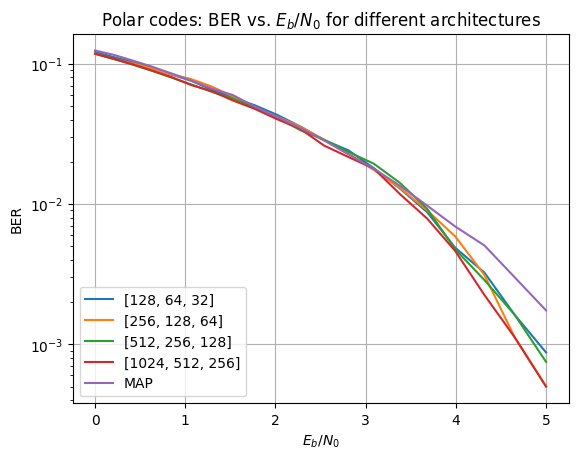

In [ ]:
legend = []
code = 'polar'
for i in range(len(archs)):
  plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), arc_errors_p_full[i]/arc_bits_p_full[i])
  legend.append(str(archs[i]))


result_map = np.loadtxt('/content/drive/MyDrive/research/results_{}_map_{}_{}.txt'.format(code,N,k), delimiter=',')
sigmas_map = result_map[:,0]
nb_bits_map = result_map[:,1]
nb_errors_map = result_map[:,2]
plt.plot(10*np.log10(1/(2*sigmas_map**2)) - 10*np.log10(k/N), nb_errors_map/nb_bits_map)
legend.append('MAP')

plt.title("Polar codes: BER vs. $E_b/N_0$ for different architectures")
plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')

plt.grid(True)
plt.show()

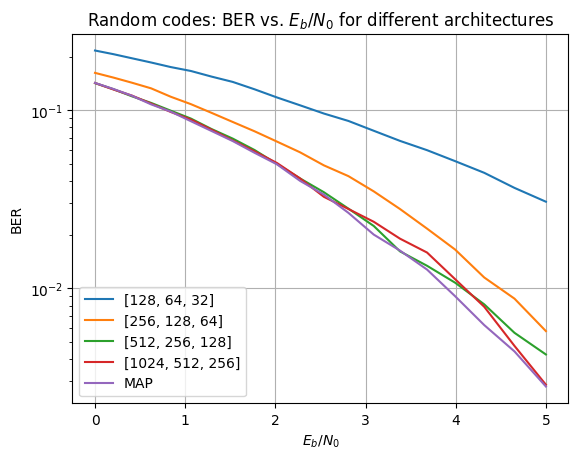

In [ ]:
legend = []
code = 'random'
for i in range(len(archs)):
  plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), arc_errors_r_full[i]/arc_bits_r_full[i])
  legend.append(str(archs[i]))


result_map = np.loadtxt('/content/drive/MyDrive/research/results_{}_map_{}_{}.txt'.format(code,N,k), delimiter=',')
sigmas_map = result_map[:,0]
nb_bits_map = result_map[:,1]
nb_errors_map = result_map[:,2]
plt.plot(10*np.log10(1/(2*sigmas_map**2)) - 10*np.log10(k/N), nb_errors_map/nb_bits_map)
legend.append('MAP')

plt.title("Random codes: BER vs. $E_b/N_0$ for different architectures")
plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')

plt.grid(True)
plt.show()

Random linear ldpc codes


In [ ]:
#load ldpc codes from matlab file
code = "random_linear"

decoder_rl, model_rl = create_decoder_model(LLR, train_sigma)
x_rl, d_rl = generate_data(k, N, code)

#noise and modulator is built into model so it generates different noise for ever epoch
model_rl.fit(x_rl, d_rl, batch_size=batch_size, epochs=nb_epoch, verbose=0, shuffle=True)
rl_errors, rl_bits = evaluate_model(x_rl, decoder_rl, LLR, code, test_batch, num_words, sigmas)

In [ ]:
code = "random"
decoder, model = create_decoder_model(LLR, train_sigma)
x, d = generate_data(k, N, code)

#noise and modulator is built into model so it generates different noise for ever epoch
history = model.fit(x, d, batch_size=batch_size, epochs=nb_epoch, verbose=0, shuffle=True)
r_errors, r_bits = evaluate_model(x, decoder, LLR, code, test_batch, num_words, sigmas)



graphing random linear vs random


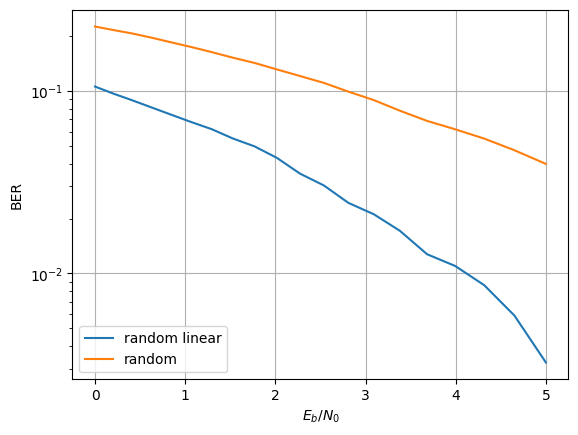

In [ ]:
legend = []

plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), rl_errors/rl_bits)
legend.append('random linear')

plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), r_errors/r_bits)
legend.append('random')

plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')
plt.grid(True)
plt.show()

random linear codes over epochs

In [ ]:
code = 'random_linear'
epochs = [2**10, 2**12, 2**14, 2**16, 2**18]


#2d lists  - each list is a different epoch length and the data within the list corresponds to different SNRs
errors_ep = []
bits_ep = []


#train and evaluate the model for each amount of epochs
for e in epochs:
  decoder, model = create_decoder_model(LLR, train_sigma)
  x, d = generate_data(k, N, code)
  history = model.fit(x, d, batch_size=batch_size, epochs=e, verbose=0, shuffle=True)

  sig_errors = []
  sig_bits = []

  sig_errors, sig_bits = evaluate_model(x, decoder, LLR, code, test_batch, num_words, sigmas)

  errors_ep.append(sig_errors)
  bits_ep.append(sig_bits)

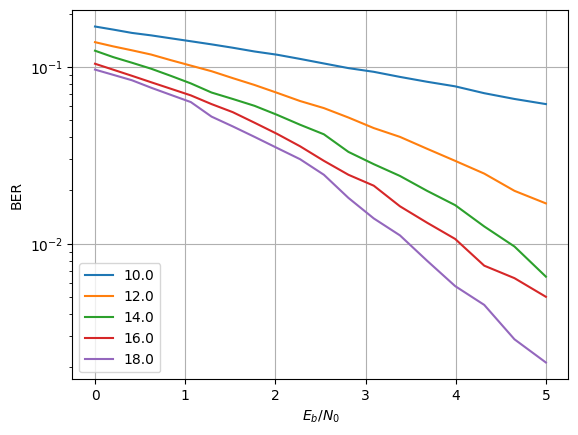

In [ ]:
legend = []
for i in range(len(epochs)):
  plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), errors_ep[i]/bits_ep[i])
  legend.append(str(math.log2(epochs[i])))




plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')

plt.grid(True)
plt.show()

functions for LDPC / random linear. These functions are for testing. The ones in use are incorporated into the code above

In [ ]:
def gf2elim(M):

    m,n = M.shape
    i=0
    j=0
    while i < m and j < n:
        # find value and index of largest element in remainder of column j
        k = np.argmax(M[i:, j]) +i
        # swap rows
        #M[[k, i]] = M[[i, k]] this doesn't work with numba
        temp = np.copy(M[k])
        M[k] = M[i]
        M[i] = temp
        aijn = M[i, j:]
        col = np.copy(M[:, j]) #make a copy otherwise M will be directly affected
        col[i] = 0 #avoid xoring pivot row with itself
        flip = np.outer(col, aijn)
        M[:, j:] = M[:, j:] ^ flip

        i += 1
        j +=1
    return M

def gf2elim2(M):
    m, n = M.shape
    i = 0
    j = 0
    while i < m and j < n:
        # Find row with a non-zero element in column j
        non_zero_row = None
        for k in range(i, m):
            if M[k, j] == 1:
                non_zero_row = k
                break

        if non_zero_row is not None:
            # Swap rows
            M[[i, non_zero_row]] = M[[non_zero_row, i]]

            # Perform XOR operation for all rows except the pivot row
            for u in range(m):
                if u != i and M[u, j] == 1:
                    M[u, :] = M[u, :] ^ M[i, :]

            i += 1
        j += 1

    return M


def generate_pcheck(k, N):
  mat = np.zeros((N - k, N))
  K = 8
  J = 4

  cols = np.zeros((int((N - k)/J), N))

  for i in range(int((N-k) / J)):
    cols[i, (i*K):i*K+K] = 1

  mat[:int((N - k)/J),:] = cols

  for i in range(1, J):
    mat = permutate_cols(mat, cols, i*int((N - k)/J),(i+1)*int((N - k)/J),  N, K)

  #if (np.linalg.matrix_rank(mat) < N-k-2):
    #mat = generate_pcheck(k, N)
  #mat = increase_rank(mat, k, N)

  return mat

def is_independent(matrix):
    return np.linalg.matrix_rank(matrix) == matrix.shape[1]

#get a low density matrix of a certain rank
def rank_mat(k, N):
  m = np.random.choice([True, False], size=(N-k, N)).astype(int)
  if (np.sum(m)< ((N-k)*N)/2 or np.linalg.matrix_rank(m) != N-k):
    return m
  else:
    return rank_mat(k, N)

#parity check matrix for irregular ldpc code
#columns and rows do not have uniform values
def generate_pcheck_ir(k, N):
  m = rank_mat(k, N)
  n = m.shape[1]
  for i in range(k):
      for j in range(i, n):
        temp_matrix = m[:, list(range(i)) + [j]]
        if is_independent(temp_matrix):
          # Swap columns
          m[:, [i, j]] = m[:, [j, i]]
          break
  return m


#arrange the N - k rows until a sufficient rank is reached
def increase_rank(mat, k, N):
  print(mat)
  print((np.linalg.matrix_rank(mat)))
  permuted_indices = np.random.permutation(N - k)
  mat = mat[permuted_indices, :]
  if (np.linalg.matrix_rank(mat) < N -k):
    mat = increase_rank(mat, k, N)
  return mat


def permutate_cols(mat, cols, row_idx, row_idx_stop, N, K):
  permuted_indices = np.random.permutation(N)
  # Use the permutation to permute the columns of the original array
  cols = cols[:, permuted_indices]

  mat[row_idx:row_idx_stop,:] = cols
  print()


  result = np.sum(mat, axis=0) > K
  if np.sum(result) != 0:
    mat = permutate_cols(mat, cols, row_idx, row_idx_stop, N, K)


  return mat;

def obtain_generator(k, N, parity_check):
    inter = parity_check.astype(int)
    #inter = np.concatenate([inter[:, N -  k:], inter[:, :N - k]], axis=1)
    inter = gf2elim2(inter)
    print(inter)

    for i in range(N-k):

      if inter[i][i] != 1 or np.sum(inter[:, i]) != 1:
        for j in range(i+1,N):
          if inter[i][j] == 1 and np.sum(inter[:, j]) == 1:
             #inter[:, [i, j]] = inter[:, [j, i]]
             col = inter[:, j]
             inter[:, i] = inter[:, j]
             inter[:, j] = col

    print(inter)
    inter = np.concatenate([ inter[:, k:].T, inter[:, :k]], axis=1)
    return inter.astype(bool)




In [ ]:
#code for testing ldpc generators


In [ ]:
import sympy as sp

k_test = 8
N_test = 16
#p_check = generate_pcheck(k_test, N_test)


p_check = generate_pcheck_ir(k_test, N_test)

print('Parity check mat:\n', p_check.astype(int), '\n')
gen = obtain_generator(k_test, N_test, p_check)
#gen = generate_ldpc_generator_matrix(p_check,N_test,  k_test)
print('Generator mat:\n',gen.astype(int), '\n')
d_test = np.zeros((2**k_test,k_test),dtype=bool)
for i in range(1, 2**k_test):
    d_test[i]= inc_bool(d_test[i-1])

print('Data:\n', d_test.astype(int), '\n')
codewords = (np.dot(d_test.astype(int), gen.astype(int)) % 2).astype(bool)

print('Codewords:\n',codewords.astype(int), '\n')

check = (np.dot(p_check.astype(int), codewords.T.astype(int)) % 2).astype(bool)
print('Verification matrix:\n',check.astype(int), '\n')
print (sum(check))




Parity check mat:
 [[1 0 0 1 1 1 1 0 0 1 1 0 1 0 1 1]
 [1 1 0 1 1 1 1 0 0 0 0 0 1 0 0 1]
 [1 0 0 1 0 0 0 0 0 1 1 0 0 1 1 0]
 [1 0 1 0 0 1 1 0 1 0 0 0 1 1 0 0]
 [0 0 1 0 1 0 0 1 1 1 1 0 1 0 0 0]
 [0 1 0 1 1 0 0 0 0 1 1 1 1 0 0 0]
 [1 0 0 1 0 0 0 1 0 1 1 0 1 1 0 1]
 [1 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0]] 

Generator mat:
 [[0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [1 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0]
 [0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0]
 [0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0]
 [1 1 0 0 1 0 1 1 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1]] 

Data:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]
 ...
 [1 1 1 ... 1 0 1]
 [1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 1]] 

Codewords:
 [[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 1]
 [1 1 0 ... 0 1 0]
 ...
 [0 0 1 ... 1 0 1]
 [1 1 0 ... 1 1 0]
 [1 1 1 ... 1 1 1]] 

Verification matrix:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 